<a href="https://colab.research.google.com/github/saykim/AI_ML_DS/blob/main/%5BFastai%5Dresnet%EB%93%B1_%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision.models import mobilenet_v2
mobilenetv2 = mobilenet_v2(pretrained=True)

# 이미지 왜곡 포함
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_items=get_image_files,
    get_y=lambda x: 'ng' if parent_label(x) != 'good' else 'good',
    item_tfms=[
        RandomResizedCrop(224, min_scale=0.8)
    ],
    batch_tfms=[
        Normalize.from_stats(*imagenet_stats),
        RandomResizedCrop(256, min_scale=0.9),
        *aug_transforms(
            max_rotate=0.5,
            min_zoom=0.9,
            max_zoom=1.1,
            max_lighting=0.1,
            max_warp=0.1,
            p_affine=0.1,
            p_lighting=0.1
        ),
        Dihedral(p=0.1),
    ]
)

dls = dblock.dataloaders(path, bs=16)
dls.show_batch()


# EarlyStoppingCallback 정의
early_stop = EarlyStoppingCallback(monitor='valid_loss', patience=5)
# SaveModelCallback 정의
save_model = SaveModelCallback(monitor='valid_loss', fname='fastai_mobilenet_best_model')

learn = Learner(dls, mobilenetv2, metrics=[accuracy, F1Score(average='macro'), Recall(average='macro')], cbs=[early_stop, save_model])

learn.fine_tune(10)


In [ ]:
# 모델의 accuracy, f1 score, recall 출력
accuracy_value = learn.validate()[1]
f1_score_value = learn.metrics[1].value
recall_value = learn.metrics[2].value

print('accuracy:', accuracy_value)
print('Recall:', recall_value)
print('F1 score:', f1_score_value)

In [ ]:
# 예측값과 실제값 추출
interp = ClassificationInterpretation.from_learner(learn)
preds, targs = interp.top_losses()

interp.plot_confusion_matrix()

In [ ]:
# 오답 결과 시각# 오답 결과 시각화
interp.plot_top_losses(9, figsize=(10,7))

# resnet

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jul 24 14:41:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import fastai
import os
import warnings
warnings.filterwarnings('ignore')

import fastai
import torch
from fastai.vision.all import *
from PIL import Image
import cv2
from fastai.metrics import accuracy, F1Score, Recall
from fastai.interpret import ClassificationInterpretation
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback


from torchvision.models import mobilenet_v2
mobilenetv2 = mobilenet_v2(pretrained=True)


fastai.__version__

defaults.device = torch.device('cuda') # makes sure the gpu is used

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 267MB/s]


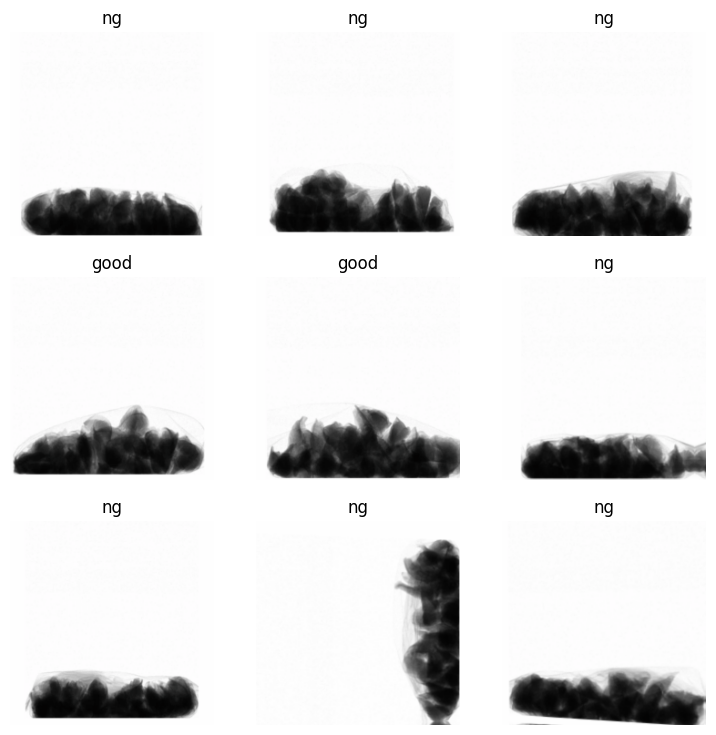

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train'


# 기본 문법
# dblock = DataBlock(
#     blocks=(ImageBlock, CategoryBlock),
#     splitter=RandomSplitter(valid_pct=0.2, seed=42),
#     get_items=get_image_files,
#     get_y=lambda x: 'ng' if parent_label(x) != 'good' else 'good',
#     item_tfms=[Resize(224)],
#     batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]
# )


# 이미지 왜곡 포함
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_items=get_image_files,
    get_y=lambda x: 'ng' if parent_label(x) != 'good' else 'good',
    item_tfms=[
        RandomResizedCrop(224, min_scale=0.8)
    ],
    batch_tfms=[
        Normalize.from_stats(*imagenet_stats),
        RandomResizedCrop(256, min_scale=0.9),
        *aug_transforms(
            max_rotate=10,
            min_zoom=0.9,
            max_zoom=1.1,
            max_lighting=0.1,
            max_warp=0.1,
            p_affine=0.1,
            p_lighting=0.1
        ),
        Dihedral(p=0.1),
    ]
)

dls = dblock.dataloaders(path, bs=16)
dls.show_batch()

In [ ]:
# EarlyStoppingCallback 정의
early_stop = EarlyStoppingCallback(monitor='valid_loss', patience=5)
# SaveModelCallback 정의
save_model = SaveModelCallback(monitor='valid_loss', fname='fastai_resnet_best_model')

learn = Learner(dls, mobilenetv2, metrics=[accuracy,Precision(average='macro'), Recall(average='macro'), F1Score(average='macro')], cbs=[early_stop, save_model])

learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.826193,1.855142,0.540984,0.600000,0.740741,0.491667,00:05


Better model found at epoch 0 with valid_loss value: 1.8551418781280518.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.144798,1.764212,0.584699,0.608247,0.765432,0.524740,00:05
1,0.205709,0.437840,0.890710,0.945055,0.523810,0.516385,00:05
2,0.164470,0.243961,0.918033,0.957627,0.642857,0.700098,00:05
3,0.173178,0.049017,0.989071,0.973104,0.973104,0.973104,00:05
4,0.120269,0.043965,0.972678,0.960101,0.901675,0.928252,00:05
5,0.113145,0.190772,0.907104,0.776316,0.947531,0.828245,00:05
6,0.094732,0.113647,0.956284,0.862069,0.975309,0.907342,00:05
7,0.070046,0.017758,0.994536,0.996933,0.976190,0.986266,00:05
8,0.068088,0.017719,0.989071,0.973104,0.973104,0.973104,00:05
9,0.051765,0.023176,0.994536,0.977273,0.996914,0.986824,00:05


Better model found at epoch 0 with valid_loss value: 1.7642121315002441.
Better model found at epoch 1 with valid_loss value: 0.43784016370773315.
Better model found at epoch 2 with valid_loss value: 0.24396108090877533.
Better model found at epoch 3 with valid_loss value: 0.049016743898391724.
Better model found at epoch 4 with valid_loss value: 0.043964724987745285.
Better model found at epoch 7 with valid_loss value: 0.017757834866642952.
Better model found at epoch 8 with valid_loss value: 0.017718816176056862.


In [ ]:
# 모델의 검증 손실 및 메트릭 계산
loss, accuracy_value, precision_value, recall_value, f1_score_value = learn.validate()

print('Accuracy:', accuracy_value)
print('Precision:', precision_value)
print('Recall:', recall_value)
print('F1 score:', f1_score_value)

Better model found at epoch 0 with valid_loss value: 0.9890710115432739.
Accuracy: 0.9890710115432739
Precision: 0.9731040564373897
Recall: 0.9731040564373897
F1 score: 0.9731040564373897


In [ ]:
# 예측값과 실제값 추출
interp = ClassificationInterpretation.from_learner(learn)
preds, targs = interp.top_losses()

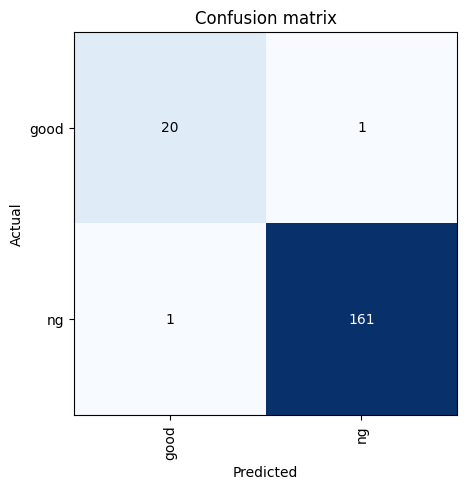

In [ ]:
interp.plot_confusion_matrix()

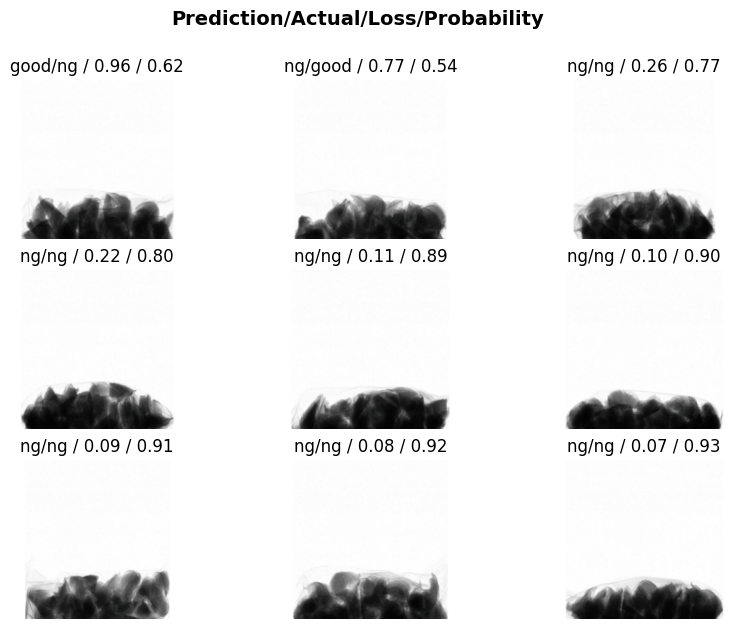

In [ ]:
# 오답 결과 시각# 오답 결과 시각화

interp.plot_top_losses(9, figsize=(10,7))


In [ ]:
import glob

# 테스트 이미지 경로
test_images = glob.glob('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/valid/*.jpg')

for image_path in test_images:
    img = PILImage.create(image_path)
    pred,pred_idx,probs = learn.predict(img)
    print(f"Image: {image_path}, Prediction: {pred}, Probability: {probs[pred_idx]}")


Image: /content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/valid/2022-12-27-145837685.jpg, Prediction: good, Probability: 0.9998708963394165


Image: /content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/valid/2022-12-27-145919738.jpg, Prediction: good, Probability: 0.9983731508255005


Image: /content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/valid/2022-12-27-145602769.jpg, Prediction: good, Probability: 0.9812636375427246


Image: /content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/valid/2022-12-27-153729773.jpg, Prediction: ng, Probability: 0.9684699773788452


Image: /content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/valid/2022-12-27-153741302.jpg, Prediction: ng, Probability: 0.9987264275550842


IndexError: ignored

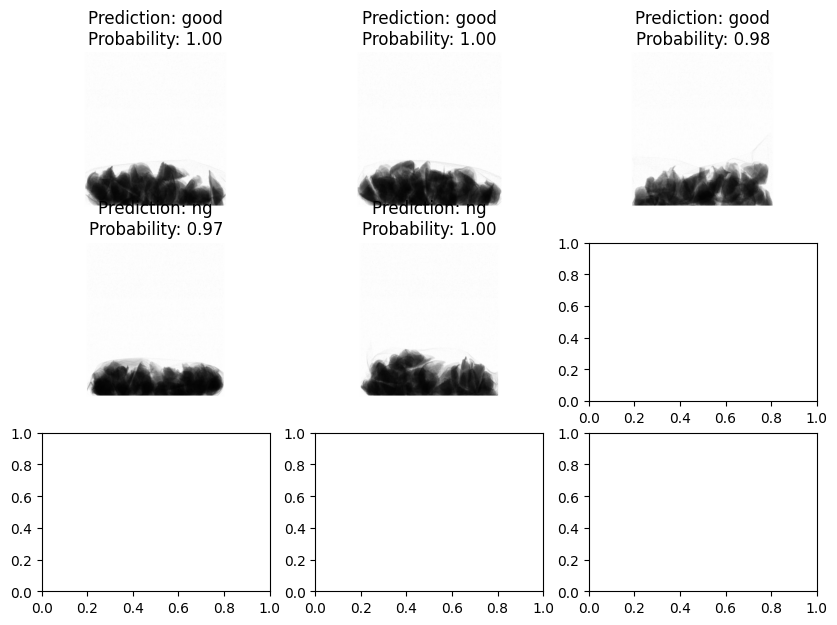

In [ ]:
import matplotlib.pyplot as plt
import glob

# 테스트 이미지 경로
test_images = glob.glob('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/valid/*.jpg')

fig, axs = plt.subplots(3, 3, figsize=(10, 7))  # 3x3 grid for displaying images

for i, ax in enumerate(axs.flatten()):
    img = PILImage.create(test_images[i])
    pred,pred_idx,probs = learn.predict(img)

    ax.imshow(img)
    ax.set_title(f"Prediction: {pred}\nProbability: {probs[pred_idx]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()


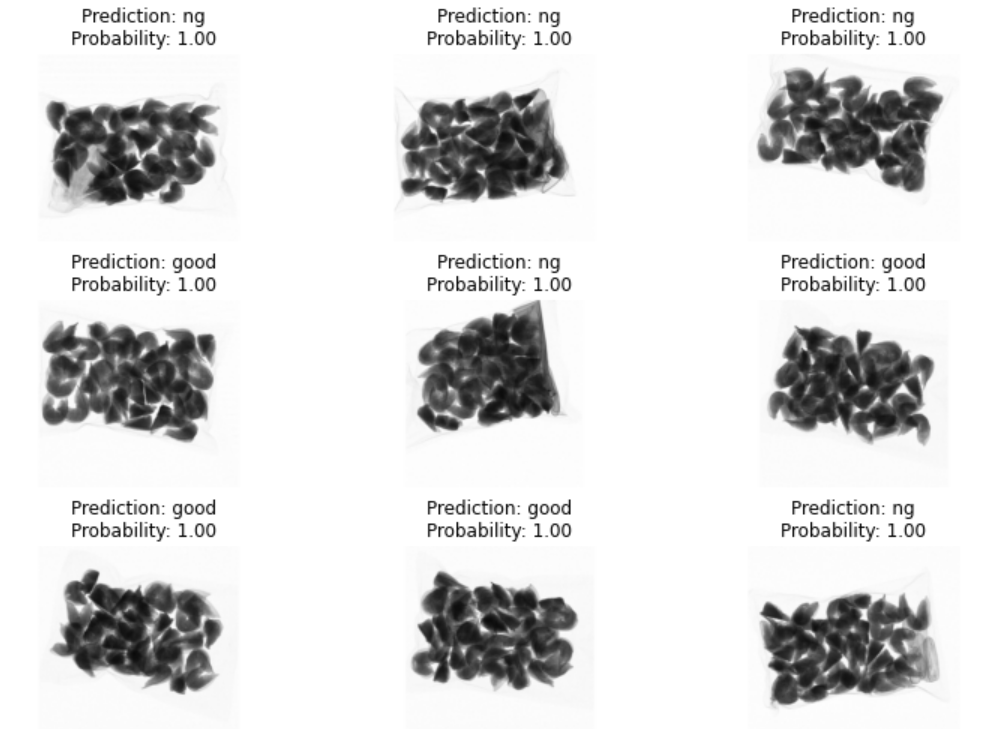

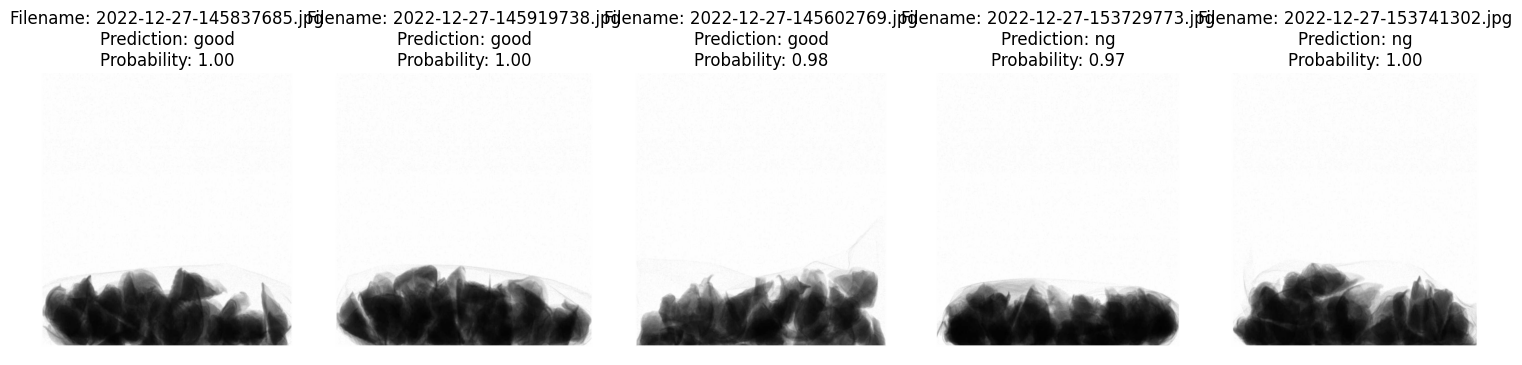

In [ ]:
# 파일명 추가
import os
import matplotlib.pyplot as plt
import glob

# 테스트 이미지 경로
test_images = glob.glob('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/valid/*.jpg')

fig, axs = plt.subplots(1, 5, figsize=(15, 8))  # 3x3 grid for displaying images

for i, ax in enumerate(axs.flatten()):
    img = PILImage.create(test_images[i])
    pred,pred_idx,probs = learn.predict(img)

    filename = os.path.basename(test_images[i])  # Extract filename from the image path

    ax.imshow(img)
    ax.set_title(f"Filename: {filename}\nPrediction: {pred}\nProbability: {probs[pred_idx]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()
